In [1]:
!git clone https://github.com/stopwords/vietnamese-stopwords.git

Cloning into 'vietnamese-stopwords'...


In [1]:
pip install pandas scikit-learn tensorflow pyvi openpyxl matplotlib

     ---------------------------------------- 8.5/8.5 MB 1.4 MB/s eta 0:00:00
     ------------------------------------ 250.9/250.9 kB 733.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 1: Import các thư viện cần thiết
import pandas as pd
import numpy as np
import re # Thư viện regex để làm sạch text
import pickle # Để lưu tokenizer và label encoder
import matplotlib.pyplot as plt # Để vẽ đồ thị

# Thư viện tiền xử lý và tách từ tiếng Việt
from pyvi import ViTokenizer

# Thư viện Machine Learning từ Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Thư viện Deep Learning từ TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
# Add any other library version checks if needed

TensorFlow version: 2.19.0
Pandas version: 2.2.3


In [6]:
# Cell 2: Định nghĩa các hằng số và tham số
# --- Tham số dữ liệu ---
DATA_FILE = 'data.xlsx' 
COMMENT_COLUMN = 'Comment' # <<=== THAY ĐỔI TÊN CỘT COMMENT NẾU CẦN
EMOTION_COLUMN = 'Emotion' # <<=== THAY ĐỔI TÊN CỘT EMOTION NẾU CẦN

# Đường dẫn file stopwords
STOPWORDS_FILE = 'vietnamese-stopwords/vietnamese-stopwords.txt'

# --- Tham số tiền xử lý ---
MAX_NUM_WORDS = 20000  # Số lượng từ tối đa trong từ vựng (kích thước vocabulary)
MAX_SEQUENCE_LENGTH = 150  # Độ dài tối đa của một chuỗi (comment) sau padding

# --- Tham số model ---
EMBEDDING_DIM = 128  # Kích thước của vector embedding
LSTM_UNITS = 64     # Số units trong mỗi LSTM layer
DROPOUT_RATE = 0.3  # Tỷ lệ dropout để chống overfitting

# --- Tham số huấn luyện ---
BATCH_SIZE = 64
EPOCHS = 20 # Có thể tăng nếu cần, EarlyStopping sẽ giúp dừng sớm
LEARNING_RATE = 1e-3 # Tốc độ học của optimizer

# --- Đường dẫn lưu model và các đối tượng khác ---
MODEL_SAVE_PATH = 'vietnamese_emotion_bilstm_model.keras' # Keras 3.0+ ưu tiên .keras, .h5 cũng được
TOKENIZER_SAVE_PATH = 'tokenizer.pickle'
LABEL_ENCODER_SAVE_PATH = 'label_encoder.pickle'



In [7]:
# Cell 3: Tải và kiểm tra dữ liệu
try:
    # Đọc file Excel. Cần có 'openpyxl' được cài đặt.
    df = pd.read_excel(DATA_FILE)
    print("Tải dữ liệu thành công!")
    print("Thông tin DataFrame:")
    df.info()
    print("\n5 dòng đầu tiên của dữ liệu:")
    print(df.head())
    print(f"\nSố lượng mẫu ban đầu: {len(df)}")

    # Kiểm tra sự tồn tại của các cột cần thiết
    if COMMENT_COLUMN not in df.columns or EMOTION_COLUMN not in df.columns:
        raise ValueError(f"Lỗi: Không tìm thấy cột '{COMMENT_COLUMN}' hoặc '{EMOTION_COLUMN}' trong file. Các cột hiện có: {df.columns.tolist()}")

    # Loại bỏ các dòng có giá trị NaN ở cột comment hoặc emotion
    df.dropna(subset=[COMMENT_COLUMN, EMOTION_COLUMN], inplace=True)
    print(f"Số lượng mẫu sau khi loại bỏ NaN: {len(df)}")

    # Đảm bảo kiểu dữ liệu của cột comment và emotion là string
    df[COMMENT_COLUMN] = df[COMMENT_COLUMN].astype(str)
    df[EMOTION_COLUMN] = df[EMOTION_COLUMN].astype(str)

    if df.empty:
        raise ValueError("Lỗi: Không có dữ liệu nào sau khi làm sạch NaN. Vui lòng kiểm tra lại file Excel.")

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file '{DATA_FILE}'. Hãy đảm bảo file nằm đúng đường dẫn và bạn đã thay đổi DATA_FILE trong Cell 2 nếu cần.")
    raise # Dừng thực thi nếu file không tìm thấy
except ValueError as ve:
    print(f"Lỗi dữ liệu: {ve}")
    raise
except Exception as e:
    print(f"Có lỗi không xác định xảy ra khi tải dữ liệu: {e}")
    raise

# Lấy danh sách comments và nhãn
texts = df[COMMENT_COLUMN].tolist()
emotion_labels_text = df[EMOTION_COLUMN].tolist()

print(f"\nTổng số comments sẽ được xử lý: {len(texts)}")
print(f"Tổng số nhãn tương ứng: {len(emotion_labels_text)}")
if texts:
    print("\nVí dụ comment đầu tiên:", texts[0])
    print("Ví dụ nhãn đầu tiên:", emotion_labels_text[0])
else:
    print("Không có dữ liệu để xử lý.")

Tải dữ liệu thành công!
Thông tin DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542 entries, 0 to 5541
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5517 non-null   object
 1   Emotion  5521 non-null   object
dtypes: object(2)
memory usage: 86.7+ KB

5 dòng đầu tiên của dữ liệu:
                                             Comment Emotion
0  13/1/2017 mv Bống Bống Bang Bang đã cán mốc 10...  vui vẻ
1  hành động của Isaac đối với ST trolàn sóng xan...  vui vẻ
2  Trước thềm chuẩn bị sang 1 năm mới thì muốn ng...  vui vẻ
3                             Hay Quá! Đẹp troai nữa  vui vẻ
4  Nhà cả con cả cháu nội ngoại mười mấy đứa, xuấ...  vui vẻ

Số lượng mẫu ban đầu: 5542
Số lượng mẫu sau khi loại bỏ NaN: 5517

Tổng số comments sẽ được xử lý: 5517
Tổng số nhãn tương ứng: 5517

Ví dụ comment đầu tiên: 13/1/2017 mv Bống Bống Bang Bang đã cán mốc 100 triệu views . Congrats 365 daband đã xác lập 2 kỷ lục mới

In [8]:
# Tải stopwords từ file
try:
    with open(STOPWORDS_FILE, 'r', encoding='utf-8') as f:
        vietnamese_stopwords = set(f.read().splitlines())
    print(f"Tải thành công {len(vietnamese_stopwords)} stopwords.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file stopwords '{STOPWORDS_FILE}'.")
    vietnamese_stopwords = set()

Tải thành công 1942 stopwords.


In [9]:
# Cell 4: Tiền xử lý văn bản và Mã hóa Nhãn

# 4.1. Hàm làm sạch văn bản
def clean_text_vietnamese(text):
    text = str(text)  # Đảm bảo là string
    text = re.sub(r"http\S+", "", text)  # Loại bỏ URL
    text = re.sub(r"@\w+", "", text)  # Loại bỏ mentions (@user)
    text = re.sub(r"#\w+", "", text)  # Loại bỏ hashtags (#tag)
    text = re.sub(r"[^\w\sÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ]", " ", text)  # Loại bỏ ký tự đặc biệt
    text = text.lower()  # Chuyển thành chữ thường
    text = re.sub(r"\s+", " ", text).strip()  # Chuẩn hóa khoảng trắng (thay nhiều khoảng trắng bằng 1, xóa đầu/cuối)
    # Loại bỏ stopwords
    text = " ".join(word for word in text.split() if word not in vietnamese_stopwords)
    return text


print("Đang làm sạch văn bản...")
cleaned_texts = [clean_text_vietnamese(text) for text in texts]
if cleaned_texts:
    print("Ví dụ comment sau khi làm sạch:", cleaned_texts[0])

# 4.2. Tách từ tiếng Việt (Word Segmentation)
print("\nĐang tách từ tiếng Việt...")
# Sử dụng ViTokenizer.tokenize để tách từ
tokenized_texts = [ViTokenizer.tokenize(text) for text in cleaned_texts]
if tokenized_texts:
    print("Ví dụ comment sau khi tách từ:", tokenized_texts[0])

# 4.3. Mã hóa nhãn cảm xúc (Label Encoding)
print("\nĐang mã hóa nhãn cảm xúc...")
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(emotion_labels_text) # Fit và transform
num_classes = len(label_encoder.classes_) # Số lượng lớp cảm xúc

print(f"Đã tìm thấy {num_classes} lớp cảm xúc độc nhất.")
print("Các lớp cảm xúc (theo thứ tự mã hóa):", list(label_encoder.classes_)) # In ra danh sách các lớp

# In ra ánh xạ từ nhãn text sang số
print("Ánh xạ từ nhãn text sang số:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"'{class_name}'  ---->  {i}")

if numerical_labels.size > 0:
    print("Ví dụ 5 nhãn đầu tiên (dạng số):", numerical_labels[:5])

# Chuyển nhãn số thành dạng one-hot encoding (cần cho 'categorical_crossentropy')
categorical_labels = to_categorical(numerical_labels, num_classes=num_classes)
if categorical_labels.size > 0:
    print("Ví dụ nhãn đầu tiên (dạng one-hot):", categorical_labels[0])

# Lưu Label Encoder để sử dụng sau này (ví dụ: khi dự đoán trên dữ liệu mới)
with open(LABEL_ENCODER_SAVE_PATH, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"Label encoder đã được lưu vào '{LABEL_ENCODER_SAVE_PATH}'")

Đang làm sạch văn bản...
Ví dụ comment sau khi làm sạch: 13 1 2017 mv bống bống bang bang cán mốc 100 triệu views congrats 365 daband xác lập 2 kỷ lục nhạc vn 100tr views 200 days nhạc đầu tiên vn mv 100tr views mừng stellars

Đang tách từ tiếng Việt...
Ví dụ comment sau khi tách từ: 13 1 2017 mv bống bống bang bang cán mốc 100 triệu views congrats 365 daband xác_lập 2 kỷ_lục nhạc vn 100tr views 200 days nhạc đầu_tiên vn mv 100tr views mừng stellars

Đang mã hóa nhãn cảm xúc...
Đã tìm thấy 6 lớp cảm xúc độc nhất.
Các lớp cảm xúc (theo thứ tự mã hóa): [np.str_('buồn bã'), np.str_('ghê tởm'), np.str_('ngạc nhiên'), np.str_('sợ hãi'), np.str_('tức giận'), np.str_('vui vẻ')]
Ánh xạ từ nhãn text sang số:
'buồn bã'  ---->  0
'ghê tởm'  ---->  1
'ngạc nhiên'  ---->  2
'sợ hãi'  ---->  3
'tức giận'  ---->  4
'vui vẻ'  ---->  5
Ví dụ 5 nhãn đầu tiên (dạng số): [5 5 5 5 5]
Ví dụ nhãn đầu tiên (dạng one-hot): [0. 0. 0. 0. 0. 1.]
Label encoder đã được lưu vào 'label_encoder.pickle'


In [10]:
# Cell 5: Tokenization văn bản và Padding sequences

print("Đang thực hiện Tokenization và Padding...")
# Khởi tạo Tokenizer của Keras
# num_words: số từ tối đa giữ lại trong vocabulary, dựa trên tần suất xuất hiện
# oov_token: token đặc biệt cho các từ không có trong vocabulary (Out-Of-Vocabulary)
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<unk>")

# Xây dựng vocabulary dựa trên các comment đã tách từ
tokenizer.fit_on_texts(tokenized_texts)

# Chuyển các comment (dạng text đã tách từ) thành chuỗi các số nguyên (sequences of integers)
sequences = tokenizer.texts_to_sequences(tokenized_texts)

word_index = tokenizer.word_index # Lấy từ điển: từ -> chỉ số
print(f"Tìm thấy {len(word_index)} từ duy nhất trong từ vựng (vocabulary).")
print(f"Kích thước vocabulary sẽ sử dụng trong Embedding layer: {min(MAX_NUM_WORDS, len(word_index) + 1)}")


# Padding sequences để đảm bảo tất cả các chuỗi có cùng độ dài (MAX_SEQUENCE_LENGTH)
# padding='post': thêm padding vào cuối chuỗi
# truncating='post': nếu chuỗi dài hơn MAX_SEQUENCE_LENGTH, cắt bỏ phần cuối
data_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("\nShape của dữ liệu đã padding (số mẫu, độ dài sequence):", data_padded.shape)
print("Shape của nhãn (số mẫu, số lớp cảm xúc):", categorical_labels.shape)
if data_padded.size > 0:
    print("Ví dụ sequence đã padding đầu tiên:", data_padded[0])

# Lưu Tokenizer để sử dụng sau này
with open(TOKENIZER_SAVE_PATH, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer đã được lưu vào '{TOKENIZER_SAVE_PATH}'")

Đang thực hiện Tokenization và Padding...
Tìm thấy 3393 từ duy nhất trong từ vựng (vocabulary).
Kích thước vocabulary sẽ sử dụng trong Embedding layer: 3394

Shape của dữ liệu đã padding (số mẫu, độ dài sequence): (5517, 150)
Shape của nhãn (số mẫu, số lớp cảm xúc): (5517, 6)
Ví dụ sequence đã padding đầu tiên: [1006   25  885  593  226  226  227  227  649 1430  486  371 1007 1893
  428 1894  650  458   35  713 1182   76  311 1183 1007 1895 1896   76
   41  135  311  593 1183 1007  651 1897    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   

In [11]:
# Cell 6: Chia dữ liệu thành tập Huấn luyện (Train), Validation và Kiểm tra (Test)
print("Đang chia dữ liệu thành tập Train, Validation, Test...")
# Chia lần 1: Train (80%) và Temp (20% - sẽ dùng cho Validation và Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    data_padded, categorical_labels,
    test_size=0.2,  # 20% cho temp
    random_state=42, # Để kết quả có thể tái tạo
    stratify=categorical_labels # Giữ tỷ lệ các lớp trong các tập con (quan trọng nếu dữ liệu mất cân bằng)
)

# Chia lần 2: Temp thành Validation (50% của Temp -> 10% tổng) và Test (50% của Temp -> 10% tổng)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, # 50% của X_temp cho test
    random_state=42,
    stratify=y_temp # Giữ tỷ lệ các lớp
)

print(f"Số lượng mẫu huấn luyện (X_train): {len(X_train)}")
print(f"Số lượng mẫu validation (X_val): {len(X_val)}")
print(f"Số lượng mẫu kiểm tra (X_test): {len(X_test)}")

Đang chia dữ liệu thành tập Train, Validation, Test...
Số lượng mẫu huấn luyện (X_train): 4413
Số lượng mẫu validation (X_val): 552
Số lượng mẫu kiểm tra (X_test): 552


In [12]:
# Cell 7: Xây dựng Model Bi-LSTM
print("Đang xây dựng model Bi-LSTM...")

model = Sequential([
    # Lớp Embedding: Chuyển các chỉ số từ (integer) thành vector dày đặc (dense vector)
    # input_dim: kích thước vocabulary + 1 (vì index 0 thường dành cho padding/OOV)
    # output_dim: kích thước của vector embedding cho mỗi từ (EMBEDDING_DIM)
    # input_length: độ dài của mỗi sequence đầu vào (MAX_SEQUENCE_LENGTH)
    # mask_zero=True: báo cho các lớp sau bỏ qua các giá trị padding (số 0) nếu chúng hỗ trợ
    Embedding(input_dim=min(MAX_NUM_WORDS, len(word_index) + 1),
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH,
              mask_zero=True),
    Dropout(DROPOUT_RATE), # Lớp Dropout để giảm overfitting

    # Lớp Bidirectional LSTM: Học thông tin từ cả hai chiều (trước ra sau và sau ra trước) của sequence
    # LSTM_UNITS: số lượng units (neurons) trong lớp LSTM
    # return_sequences=False: chỉ trả về output của timestep cuối cùng (vì lớp Dense tiếp theo không cần sequence)
    # Nếu bạn muốn xếp chồng nhiều lớp LSTM, lớp LSTM trước đó cần có return_sequences=True
    Bidirectional(LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, return_sequences=False)),

    # (Tùy chọn) Có thể thêm một lớp Dense ẩn nữa nếu muốn model phức tạp hơn
    # Dense(LSTM_UNITS // 2, activation='relu'),
    # Dropout(DROPOUT_RATE),

    # Lớp Dense Output: Phân loại thành num_classes cảm xúc
    # activation='softmax': cho output dạng xác suất cho mỗi lớp (tổng các xác suất bằng 1)
    Dense(num_classes, activation='softmax')
])

# Compile model: Cấu hình quá trình học
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', # Hàm mất mát cho bài toán phân loại đa lớp (nhãn đã one-hot)
              optimizer=optimizer,             # Thuật toán tối ưu hóa
              metrics=['accuracy'])            # Metric để theo dõi trong quá trình huấn luyện

# In cấu trúc của model
model.summary()

Đang xây dựng model Bi-LSTM...


c:\Users\DUY SAMA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Cell 8: Huấn luyện Model
print("Bắt đầu huấn luyện model...")

# Callbacks: Các hàm được gọi tại các điểm khác nhau trong quá trình huấn luyện
# EarlyStopping: Dừng huấn luyện sớm nếu một metric theo dõi (vd: val_loss) không cải thiện sau 1 số 'patience' epochs
early_stopping = EarlyStopping(
    monitor='val_loss', # Theo dõi validation loss
    patience=5,         # Số epochs chờ đợi trước khi dừng nếu không có cải thiện
    restore_best_weights=True, # Khôi phục trọng số của model từ epoch có kết quả tốt nhất
    verbose=1
)

# ModelCheckpoint: Lưu lại model (hoặc chỉ trọng số) tại các thời điểm nhất định (vd: khi val_accuracy tốt nhất)
model_checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor='val_accuracy', # Theo dõi validation accuracy
    save_best_only=True,    # Chỉ lưu model nếu val_accuracy cải thiện
    verbose=1
)

# Tiến hành huấn luyện model
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint], # Thêm các callbacks đã định nghĩa
    verbose=1 # Hiển thị thông tin huấn luyện (0: im lặng, 1: progress bar, 2: một dòng mỗi epoch)
)

print("Huấn luyện hoàn tất!")
# Model tốt nhất đã được lưu vào MODEL_SAVE_PATH (do ModelCheckpoint)
# và model hiện tại trong bộ nhớ cũng là model tốt nhất (do EarlyStopping với restore_best_weights=True)

Bắt đầu huấn luyện model...
Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4789 - loss: 1.6411
Epoch 1: val_accuracy improved from -inf to 0.78804, saving model to vietnamese_emotion_bilstm_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 361ms/step - accuracy: 0.4807 - loss: 1.6376 - val_accuracy: 0.7880 - val_loss: 0.7939
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8298 - loss: 0.6340
Epoch 2: val_accuracy improved from 0.78804 to 0.88043, saving model to vietnamese_emotion_bilstm_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 330ms/step - accuracy: 0.8301 - loss: 0.6327 - val_accuracy: 0.8804 - val_loss: 0.4189
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9201 - loss: 0.3086
Epoch 3: val_accuracy improved from 0.88043 to 0.89674, saving model to vietnamese_emotion_bilstm_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 24s 345ms/step - accuracy: 0.9201 - loss: 0.3086 - val_accuracy: 0.8967 - val_loss: 0.3370
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━

In [14]:
# Cell 9: Đánh giá Model trên tập Test
print("\nĐánh giá model trên tập Test:")

# Load lại model tốt nhất đã được lưu bởi ModelCheckpoint để đảm bảo đánh giá đúng model
# (Mặc dù EarlyStopping với restore_best_weights=True cũng đã làm điều này cho model trong bộ nhớ)
try:
    print(f"Đang tải model tốt nhất từ: {MODEL_SAVE_PATH}")
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
except Exception as e:
    print(f"Lỗi khi tải model từ file: {e}. Sẽ sử dụng model hiện tại trong bộ nhớ để đánh giá.")
    best_model = model # Sử dụng model hiện tại nếu không load được

# Đánh giá model trên tập test
loss, accuracy = best_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Dự đoán trên tập test để có thể xem các metrics chi tiết hơn
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Chuyển từ xác suất (one-hot-like) về chỉ số lớp
y_true_classes = np.argmax(y_test, axis=1) # Chuyển nhãn thật từ one-hot về chỉ số lớp

# Hiển thị Classification Report (bao gồm precision, recall, f1-score cho mỗi lớp)
print("\nClassification Report trên tập Test:")
# target_names: tên các lớp cảm xúc lấy từ label_encoder
# zero_division=0: xử lý trường hợp một lớp không có dự đoán nào (để tránh warning)
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0))

# (Tùy chọn) Hiển thị Confusion Matrix
print("\nConfusion Matrix trên tập Test:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)
# Bạn có thể vẽ Confusion Matrix đẹp hơn bằng seaborn nếu muốn
# import seaborn as sns
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()


Đánh giá model trên tập Test:
Đang tải model tốt nhất từ: vietnamese_emotion_bilstm_model.keras
Test Loss: 0.4102
Test Accuracy: 0.8804
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step

Classification Report trên tập Test:
              precision    recall  f1-score   support

     buồn bã       0.94      0.93      0.93       123
     ghê tởm       0.82      0.86      0.84       117
  ngạc nhiên       0.96      0.84      0.90        32
      sợ hãi       0.87      0.84      0.86        90
    tức giận       0.84      0.88      0.86       128
      vui vẻ       0.93      0.90      0.92        62

    accuracy                           0.88       552
   macro avg       0.90      0.88      0.89       552
weighted avg       0.88      0.88      0.88       552


Confusion Matrix trên tập Test:
[[114   1   0   2   5   1]
 [  0 101   0   6   8   2]
 [  1   2  27   0   1   1]
 [  1  11   0  76   2   0]
 [  4   8   1   3 112   0]
 [  1   0   0   0   5  56]]



Đang vẽ đồ thị learning curves...


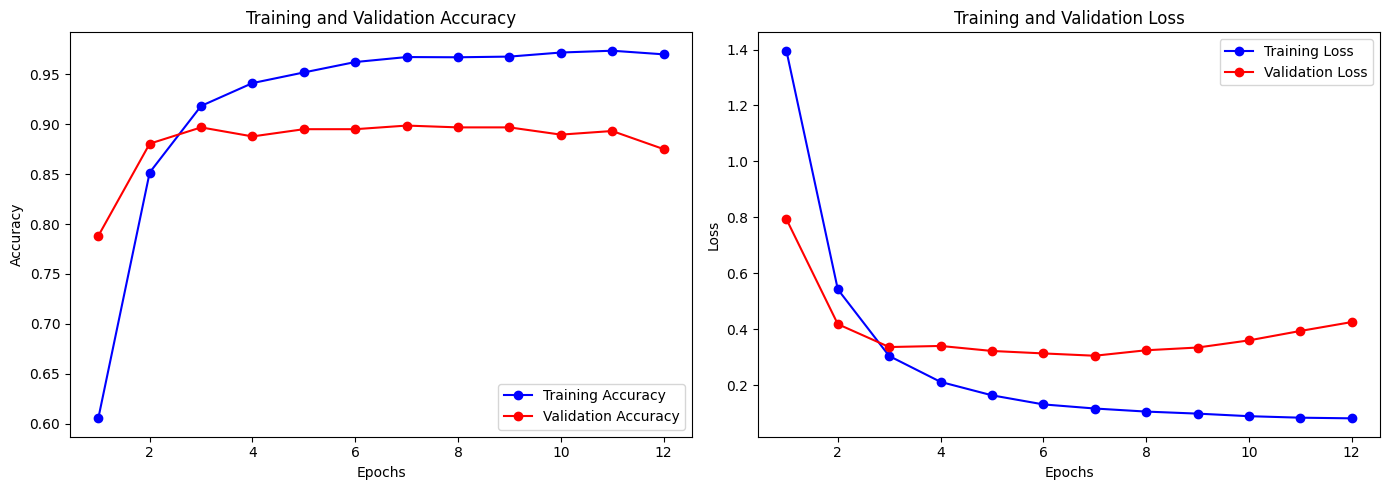

In [15]:
# Cell 10: Vẽ đồ thị Training/Validation Accuracy và Loss
if 'history' in locals() and history is not None:
    print("\nĐang vẽ đồ thị learning curves...")

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss_hist = history.history['loss'] # Đổi tên biến để không trùng với biến loss từ evaluate
    val_loss_hist = history.history['val_loss'] # Tương tự
    
    # Số epochs thực tế đã chạy (có thể ít hơn EPOCHS nếu EarlyStopping kích hoạt)
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Đồ thị Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy') # 'bo-' là blue dots and line
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy') # 'ro-' là red dots and line
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Đồ thị Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss_hist, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss_hist, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout() # Điều chỉnh layout cho đẹp
    plt.show()
else:
    print("Không có 'history' object để vẽ đồ thị. Có thể model chưa được huấn luyện hoặc có lỗi xảy ra.")

In [16]:
# Cell 11: Hướng dẫn sử dụng model đã lưu để dự đoán cho một văn bản mới
print("\n--- Hướng dẫn sử dụng model cho dự đoán mới ---")

# Giả sử bạn đã chạy các cell trên và các file đã được lưu
# 1. Load lại model, tokenizer, và label_encoder (nếu đang ở session mới)
try:
    loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    with open(TOKENIZER_SAVE_PATH, 'rb') as f_tokenizer:
        loaded_tokenizer = pickle.load(f_tokenizer)
    with open(LABEL_ENCODER_SAVE_PATH, 'rb') as f_encoder:
        loaded_label_encoder = pickle.load(f_encoder)
    print("Model, tokenizer, và label encoder đã được tải thành công.")
except Exception as e:
    print(f"Lỗi khi tải lại các đối tượng đã lưu: {e}")
    print("Vui lòng đảm bảo các file .keras và .pickle tồn tại và đúng đường dẫn.")
    # Gán lại từ các biến hiện tại nếu có lỗi (chỉ để ví dụ chạy được)
    if 'best_model' in locals(): loaded_model = best_model
    if 'tokenizer' in locals(): loaded_tokenizer = tokenizer
    if 'label_encoder' in locals(): loaded_label_encoder = label_encoder


# 2. Hàm tiền xử lý cho một đoạn văn bản mới (phải giống hệt các bước lúc train)
def preprocess_single_text(raw_text, tokenizer_obj, max_len):
    # Bước 1: Làm sạch văn bản (dùng hàm đã định nghĩa ở Cell 4)
    cleaned = clean_text_vietnamese(raw_text)
    # Bước 2: Tách từ (dùng ViTokenizer)
    tokenized = ViTokenizer.tokenize(cleaned)
    # Bước 3: Chuyển thành sequence số nguyên (dùng tokenizer đã load)
    sequence = tokenizer_obj.texts_to_sequences([tokenized]) # Chú ý: texts_to_sequences nhận vào list các text
    # Bước 4: Padding sequence (dùng pad_sequences)
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    return padded

# 3. Ví dụ dự đoán cho một comment mới
sample_comments = [
    "Trời ơi MV đẹp xuất sắc luôn, bài hát cũng hay nữa, đỉnh quá 365 ơi!!!",
    "Xem mà tức không chịu nổi, diễn viên đóng đạt dễ sợ.",
    "Bài này nghe buồn não nề, hợp với tâm trạng của mình lúc này.",
    "Cũng bình thường, không có gì đặc sắc lắm.",
    "Ngạc nhiên thật sự, không ngờ kết thúc lại như vậy."
]

if 'loaded_model' in locals() and 'loaded_tokenizer' in locals() and 'loaded_label_encoder' in locals():
    for comment in sample_comments:
        # Tiền xử lý comment mới
        processed_comment = preprocess_single_text(comment, loaded_tokenizer, MAX_SEQUENCE_LENGTH)
        
        # Dự đoán bằng model đã load
        prediction_probs = loaded_model.predict(processed_comment, verbose=0) # verbose=0 để không in progress bar
        
        # Lấy chỉ số của lớp có xác suất cao nhất
        predicted_class_index = np.argmax(prediction_probs, axis=1)[0]
        
        # Chuyển chỉ số lớp về lại nhãn text (dùng label_encoder đã load)
        predicted_emotion_label = loaded_label_encoder.inverse_transform([predicted_class_index])[0]
        
        # Lấy xác suất (độ tin cậy) của lớp dự đoán
        confidence = np.max(prediction_probs)
        
        print(f"\nInput Comment: '{comment}'")
        print(f"Predicted Emotion: {predicted_emotion_label} (Confidence: {confidence:.4f})")
        
        # (Tùy chọn) In ra xác suất của tất cả các lớp
        # probabilities_dict = {label: prob for label, prob in zip(loaded_label_encoder.classes_, prediction_probs[0])}
        # print(f"Probabilities: {probabilities_dict}")
else:
    print("Không thể thực hiện dự đoán do model, tokenizer hoặc label encoder chưa được tải.")

print("\n--- Hoàn tất quy trình ---")
print(f"Model cuối cùng đã được lưu tại: {MODEL_SAVE_PATH}")
print(f"Tokenizer đã được lưu tại: {TOKENIZER_SAVE_PATH}")
print(f"Label Encoder đã được lưu tại: {LABEL_ENCODER_SAVE_PATH}")


--- Hướng dẫn sử dụng model cho dự đoán mới ---
Model, tokenizer, và label encoder đã được tải thành công.

Input Comment: 'Trời ơi MV đẹp xuất sắc luôn, bài hát cũng hay nữa, đỉnh quá 365 ơi!!!'
Predicted Emotion: vui vẻ (Confidence: 0.9990)

Input Comment: 'Xem mà tức không chịu nổi, diễn viên đóng đạt dễ sợ.'
Predicted Emotion: tức giận (Confidence: 0.9518)

Input Comment: 'Bài này nghe buồn não nề, hợp với tâm trạng của mình lúc này.'
Predicted Emotion: buồn bã (Confidence: 0.7642)

Input Comment: 'Cũng bình thường, không có gì đặc sắc lắm.'
Predicted Emotion: vui vẻ (Confidence: 0.9908)

Input Comment: 'Ngạc nhiên thật sự, không ngờ kết thúc lại như vậy.'
Predicted Emotion: ngạc nhiên (Confidence: 0.7095)

--- Hoàn tất quy trình ---
Model cuối cùng đã được lưu tại: vietnamese_emotion_bilstm_model.keras
Tokenizer đã được lưu tại: tokenizer.pickle
Label Encoder đã được lưu tại: label_encoder.pickle
